In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from os import listdir
from os.path import join, isdir
from pathlib import Path
from pprint import pprint
import random
import csv
from collections import defaultdict


In [31]:
data_dir="/home/george/codes/gbifxdl/data/classif/20250221_cleaner_dataset"
csv_path="/home/george/codes/gbifxdl/data/classif/20250221_cleaner_dataset/fold.csv"

In [22]:
# List files
filenames = {d:[] for d in sorted(listdir(data_dir))}
for d in listdir(data_dir):
    sub_dir = join(data_dir, d)
    if isdir(sub_dir):
        for f in listdir(sub_dir):
            filenames[d] += [f]
pprint(filenames["1"][:2])

['2fd851a58db735a44438b176eeab8901487a419a.jpeg',
 '5a00c7e662526c6526747b0edb38a516e4b6bfbe.jpeg']


Explore data.

['1', '2', '3', '4', '5', '6', '7'] [11053, 446, 153, 55, 572, 430, 99]


<BarContainer object of 7 artists>

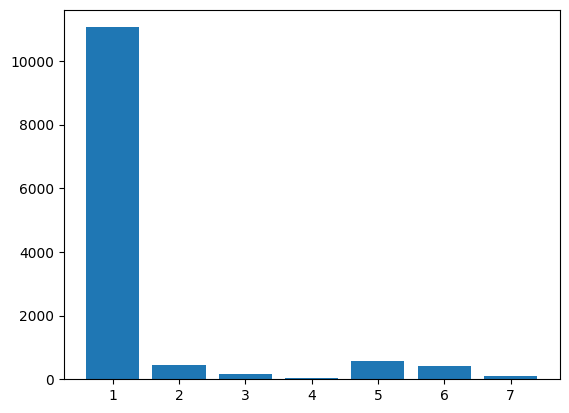

In [24]:
# Data distribution.

x = list(filenames.keys())
height = [len(v) for v in filenames.values()]

print(x, height)

plt.bar(x, height)

In [28]:
# Imbalance degree.

height = [len(v) for v in filenames.values()]
for i in range(len(height)):
    print(f"Imbalance degree: {height[i]/max(height)*100}%")

Imbalance degree: 100.0%
Imbalance degree: 4.0351035917850355%
Imbalance degree: 1.3842395729666155%
Imbalance degree: 0.497602460870352%
Imbalance degree: 5.17506559305166%
Imbalance degree: 3.890346512259115%
Imbalance degree: 0.8956844295666335%


Split the dataset into train/val/test

In [47]:
def hold_out(X, y, split_rate, seed=42):
    """
    Splits the dataset into training and test samples in a balanced fashion across classes.
    
    Args:
        X (list): List of inputs (e.g., filenames).
        y (list): List of labels corresponding to X.
        split_rate (float): Fraction of samples to assign as test per class.
        
    Returns:
        list: A binary list of length len(y), where 1 indicates a test (hold-out) sample.
    """
    random.seed(seed)
    n = len(y)
    hold_out_mask = [0] * n
    # Group indices by class label.
    class_indices = defaultdict(list)
    for i, label in enumerate(y):
        class_indices[label].append(i)
    
    # For each class, randomly sample indices for the test set.
    for label, indices in class_indices.items():
        n_samples = len(indices)
        n_test = int(round(n_samples * split_rate))
        test_indices = random.sample(indices, n_test)
        for idx in test_indices:
            hold_out_mask[idx] = 1
            
    return hold_out_mask

def stratified_kfold(X, y, n_splits, hold_out_mask=None, seed=42):
    """
    Performs stratified k-fold assignment on the dataset.
    
    For each class, training samples (or all samples if hold_out_mask is None)
    are randomly shuffled and assigned fold numbers (0 to n_splits-1) in a round-robin fashion.
    If hold_out_mask is provided, samples with hold_out==1 are skipped (their fold is left as -1).
    
    Args:
        X (list): List of inputs.
        y (list): List of labels.
        n_splits (int): Number of folds.
        hold_out_mask (list, optional): List of 0s and 1s indicating training/test. Defaults to None.
    
    Returns:
        list: A list of fold assignments (length equal to len(y)). For training samples, the fold is an integer
              in the range [0, n_splits-1]. Test samples get a fold assignment of -1.
    """
    random.seed(seed)
    n = len(y)
    folds = [-1] * n  # default: -1 for test samples
    # Group training indices by class.
    class_indices = defaultdict(list)
    for i, label in enumerate(y):
        if hold_out_mask is not None:
            if hold_out_mask[i] == 0:
                class_indices[label].append(i)
        else:
            class_indices[label].append(i)
    
    # Assign fold numbers in a round-robin fashion within each class.
    for label, indices in class_indices.items():
        random.shuffle(indices)
        for j, idx in enumerate(indices):
            folds[idx] = j % n_splits
    return folds

def save_stratified_kfold_csv(X, y, split_rate, n_splits, csv_filename):
    """
    Combines hold-out splitting and stratified k-folding, then writes the results to a CSV file.
    
    The CSV will have three columns:
      - filename (taken from X)
      - hold_out (0 for training, 1 for test)
      - fold (fold number for training samples; -1 for test samples)
    
    Args:
        X (list): List of filenames (or input identifiers).
        y (list): List of labels.
        split_rate (float): Fraction of samples per class to mark as test.
        n_splits (int): Number of folds for stratified k-folding.
        csv_filename (str): Path to the CSV file to be saved.
    """
    # First, compute the hold-out mask.
    hold_out_mask = hold_out(X, y, split_rate)
    # Next, compute stratified k-fold assignments (training samples get a fold number, test samples get -1).
    folds = stratified_kfold(X, y, n_splits, hold_out_mask)
    
    # Write the results to a CSV file.
    with open(csv_filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['filename', 'fold'])
        for filename, fold in zip(X, folds):
            writer.writerow([filename, fold])

def split_dataset(root_dir, split_rate, n_splits, csv_filename, abs_path=False):
    """
    Processes the dataset stored in a folder structure where each subfolder represents a class.
    
    It collects image file paths and their corresponding class labels (the subfolder names), 
    performs a balanced hold-out split and stratified k-folding, and saves the splits into a CSV file.
    
    The resulting CSV contains:
      - filename: full path to the image file
      - hold_out: 1 if the image is assigned as a test sample, 0 otherwise
      - fold: the fold number for training samples (0 to n_splits-1) or -1 for test samples.
    
    Args:
        root_dir (str): Path to the root directory of the dataset.
        split_rate (float): Fraction of images per class to mark as test.
        n_splits (int): Number of folds for stratified k-folding.
        csv_filename (str): Path to the CSV file to be saved.
    """
    X = []
    y = []
    # Each subdirectory in root_dir is assumed to be a class.
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # List all files in the class directory.
            for file in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file)
                if os.path.isfile(file_path):
                    if abs_path:
                        X.append(file_path)
                    else:
                        X.append(file)
                    y.append(class_name)
                    
    # Save the stratified k-fold and hold-out splits to CSV.
    save_stratified_kfold_csv(X, y, split_rate, n_splits, csv_filename)
    print(f"CSV with stratified k-fold splits saved to {csv_filename}")

In [48]:
split_dataset(
    root_dir=data_dir,
    split_rate=0.2,
    n_splits=5,
    csv_filename=csv_path
)

CSV with stratified k-fold splits saved to /home/george/codes/gbifxdl/data/classif/20250221_cleaner_dataset/fold.csv


First try. Training on the imbalance dataset.

In [49]:
df = pd.read_csv(csv_path)

In [50]:
df.head()

,filename,fold
0,4852cb5f2661d65f9b4e9612b1236bff03f466da.jpeg,4
1,3bc79f2739fb432f33e8b0ed5a83a0cd9740d21e.jpeg,3
2,499d2388b50c10a82a81f5c668bb2fbb71c60492.jpeg,0
3,3c471d003a5ce331a5f7d1cdc44412f051e17107.jpeg,-1
4,2c8d751da33caac1737bc1aed689d763169f42a4.jpeg,0
